# PART 1: PROCESSING THE sMRI WITH FREESURFER FOR 1 SUBJECT 

You can also do it with FMRI Prep, the output would be the same. 


## Step 1:
Install free surfer https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall
Remember to get and use the access key

# Step 2: Create a directory in your home folder where the processed patients will be

mkdir -p ~/freesurfer
export SUBJECTS_DIR=~/freesurfer/subjects
echo $SUBJECTS_DIR

# Step 3: Run the following bash command
recon-all -i /home/vero/TESTS/scan_mprage_anonymized.nii -s CTR_004 -all -qcache



You will end up with a bunch of folders per subject... It should look a little bit like this 

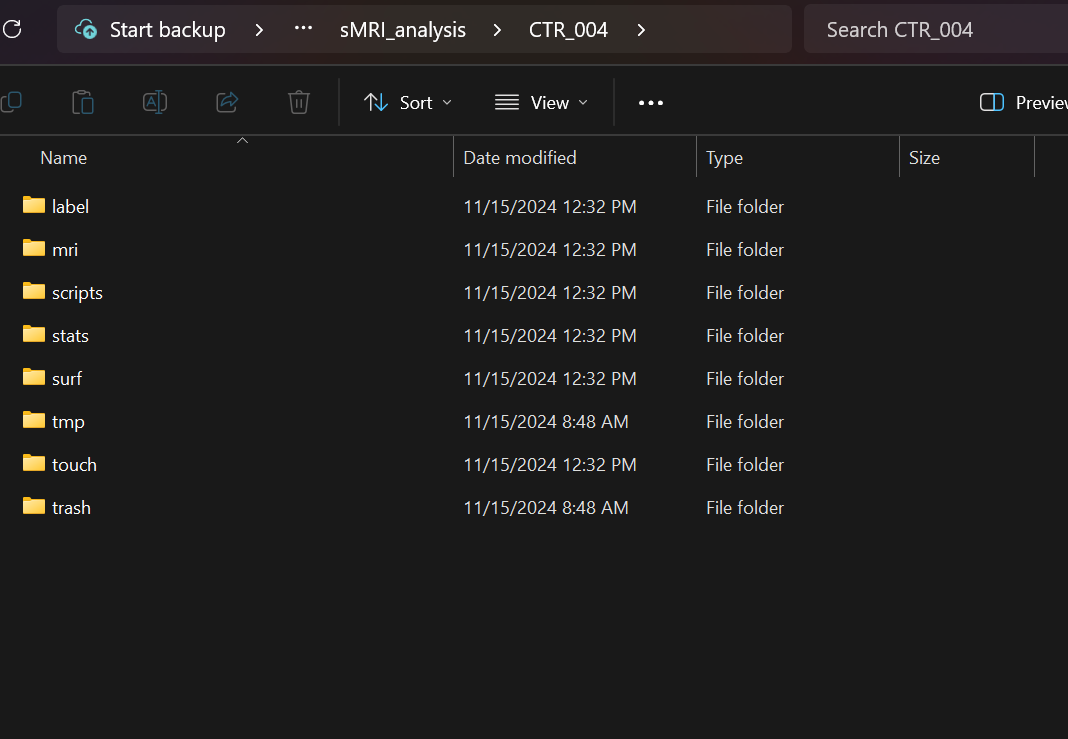

In [ ]:
# Download nilearn and nibabel

from itertools import islice
import os
import numpy as np
import subprocess
from nilearn import plotting


In [ ]:
# I am using WSL (Windows Subsystem for Linux) to run FreeSurfer, so I need to convert the path to Windows format
# Convert WSL path to Windows path
linux_path = "/home/vero/freesurfer/subjects/CTR_004/surf"
fs_rawstats_dir = subprocess.check_output(["wslpath", "-w", linux_path]).strip().decode('utf-8')

# Number of lines to read
n_lines = 110

# Open the file and read the first n lines
try:
    with open(os.path.join(fs_rawstats_dir, "aseg.stats")) as fs_stats_file:
        first_n_lines = list(islice(fs_stats_file, n_lines))
    # Print or process the first n lines
    for line in first_n_lines:
        print(line.strip())
except FileNotFoundError:
    print(f"File not found: {os.path.join(fs_rawstats_dir, 'aseg.stats')}")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# Directory containing FreeSurfer stats files

# Ensure the directory exists
if not os.path.isdir(fs_rawstats_dir):
    raise FileNotFoundError(f"Directory does not exist: {fs_rawstats_dir}")

# List files in the directory
print("Contents of stats directory:", os.listdir(fs_rawstats_dir))

# File to read
stats_file = "lh.aparc.a2009s.stats"
stats_file_path = os.path.join(fs_rawstats_dir, stats_file)

# Ensure the file exists
if not os.path.isfile(stats_file_path):
    raise FileNotFoundError(f"File does not exist: {stats_file_path}")

# Read the first n_lines from the file
n_lines = 75
with open(stats_file_path) as fs_stats_file:
    first_n_lines = list(islice(fs_stats_file, n_lines))

# Print the first n_lines
print("First", n_lines, "lines of the file:")
print("\n".join(first_n_lines))


In [ ]:
print(f"lh.pial size: {os.path.getsize(lh_pial)}")
print(f"lh.thickness size: {os.path.getsize(lh_thickness)}")
print(f"lh.sulc size: {os.path.getsize(lh_sulcus)}")


# ACA ES QUE EMPECE A TENER PROBLEMAS, NO FUI CAPAZ DE QUE VSCODE RECONOCIERA LA PARPETA DE FREESURFER QUE CONTENIA .pial EN MI SUBSITEMA DE LINUX... NO DEBERIAS TENER PROBLEMAS ACA SI HICISTE TODO LO DE ARRIBA BIEN, BUENA SUERTE MOR. RECUERDA SEGUIR EL TUTORIAL QUE TE PASE EN ESTA PAGINA. Pial esta en la carpeta surf, creo. 
https://carpentries-incubator.github.io/SDC-BIDS-sMRI/instructor/04-Image_Quantification.html

In [ ]:

# Use a predefined surface like 'fsaverage' if lh.pial is missing or corrupted
  # Corrected path for WSL
lh_pial = 'CTR_004\surf\lh.pial' # Ensure correct path
lh_thickness = 'CTR_004\surf\lh.thickness'
lh_sulcus = 'CTR_004\surf\lh.sulc'

# Lateral
plotting.plot_surf(lh_pial, surf_map=lh_thickness, hemi='left', view='lateral', bg_map=lh_sulcus);
# Medial
plotting.plot_surf(lh_pial, surf_map=lh_thickness, hemi='left', view='medial', bg_map=lh_sulcus);


# ACA COPIE Y PEGUE EL RESTO DE CODIGOS, TOCA MODIFICARLOS 

In [ ]:
SUBJECTS=(...)
MEASURE=thickness
PARC=aparc.a2009s
for HEMI in lh rh; do
    echo "Running aparcstats2table with measure ${MEASURE} and parcellation ${parc} for hemisphere ${HEMI}"
    aparcstats2table --subjects ${SUBJECTS[@]} \
        --hemi ${hemi} \
        --parc ${parc} \
        --measure ${MEASURE} \
        --tablefile ../derivatives/fs_stats/data-cortical_type-${parc}_measure-${MEASURE}_hemi-${HEMI}.tsv \
        --delimiter 'tab'           
done

In [ ]:
Then the resulting files can be read with pandas to create a dataframe including cortical thickness information for all our subjects.
PYTHON

hemi="lh"
stats_file = os.path.join(fs_stats_dir, 
                          f"data-cortical_type-aparc.a2009s_measure-thickness_hemi-{hemi}.tsv")
fs_hemi_df = pd.read_csv(stats_file,sep='\t')
fs_hemi_df

As shown in the notebook associated with the lesson we can then create a dataframe fs_df combining both data from both hemispheres, while also renaming columns to facilitate subsequent analysis.
PYTHON

fs_df

In [ ]:
plot_df = fs_df[["hemi"] + roi_cols]
## Melt dataframe for easier visualization
plot_long_df = pd.melt(plot_df, id_vars = ['hemi'], value_vars = roi_cols, 
                       var_name ='ROI', value_name ='cortical thickness')
plot_long_df

In [ ]:
g = sns.catplot(x='cortical thickness', y='ROI', hue='hemi', kind='box', data=plot_long_df)

subjects_info_withna = bids_layout.get(suffix="participants", extension=".tsv")[0].get_df()
subjects_info_withna

demo_cols = ["participant_id", "age", "sex"]
fs_all_df = pd.merge(subjects_info[demo_cols], fs_df, on='participant_id')
fs_all_df

response = 'G_and_S_cingul_Mid_Ant'
predictor = 'age'
g = sns.scatterplot(x=predictor, y=response, hue='hemi', data=plot_df)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

response = 'G_and_S_cingul_Mid_Ant'
predictor = 'age'
hemi = 'lh'
hemi_df = fs_all_df[fs_all_df['hemi']==hemi]
covariates = 'eTIV + C(sex)'
# Fit regression model
results = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()

results.summary()

# OLS result df
ols_df = pd.DataFrame()
predictor = 'age'
covariates = 'eTIV + C(sex)'
for hemi in ['lh','rh']:
    hemi_df = fs_all_df[fs_all_df['hemi']==hemi]
    for response in roi_cols:
        res = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()
        res_df = format_ols_results(res)
        res_df['response'] = response
        res_df['hemi'] = hemi
        ols_df = ols_df.append(res_df)
ols_df